In [269]:
import requests
import io
import scipy
import statsmodels.api as sm
from sklearn.feature_selection import f_regression
import numpy as np # A useful package for dealing with mathematical processes, we will be using it this week for vectors and matrices
import pandas as pd # A common package for viewing tabular data
import time # We will be using this to time the efficiency of vectorisation
import sklearn.linear_model # We want to be able to access the sklearn datasets again, also we are using some model evaluation
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn import kernel_ridge
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler # We will be using the imbuilt sclaing functions sklearn provides
import matplotlib.pyplot as plt # We will be using Matplotlib for our graphs
from mpl_toolkits import mplot3d # Used to make a 3D plot used to demonstrate multidimensional relationships.
from sklearn.preprocessing import PolynomialFeatures # A preprocessing function allowing us to include polynomial features into our model
from google.colab import files # We will be importing a csv file I have provided for one section.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # We will be using these to encode categorical features
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split # We will be using this to split our datasets into training and testing sets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score # Various classification metrics we may find useful
import seaborn as sns; sns.set()
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

# Below are a wide selection of tensorflow libraries we will need to construct our Neural networks.
from tensorflow.keras.activations import sigmoid, linear, relu # Activation functions we will use
from tensorflow.keras.models import Model, Sequential # Different mays of constructing models, we will primarily be covering the 'functional api' which uses `Model`
from tensorflow.keras.optimizers import SGD # We will be using the SGD optimiser today, though there are other options you may want to explore (such as Adam)
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy  # We will be using TFs MSE loss function for regression and BinaryCross Entropy for classification.
from tensorflow.keras.layers import Input, Dense, Dropout # The layers we will be using to construct our network.
from tensorflow.keras.regularizers import L1, L2 # Regularisation being used in model layers
from tensorflow.keras.metrics import BinaryAccuracy # Accuracy Metric for classification
from tensorflow.keras.callbacks import EarlyStopping # Allows Early Stopping regularisation method.

**Load the Data**


The data was downloaded from moodle and uploaded to my github for easy access.


In [270]:
url = "https://raw.githubusercontent.com/0xsas/courseworkDatasets/main/datasets/courseworkData.csv" # url to the dataset
download = requests.get(url).content # save the raw dataset to the variable download
df = pd.read_csv(io.StringIO(download.decode('utf-8'))) # use the ioString library to decode your data and pass it as a pandas dataframe.
df.head()

,Age,SiteSpending,SiteTime,RecommendImpression,Education,WorkType,Sex,Region,Salary
0,32,314.06,30.14,0,Degree,Private sector,Male,London,60173.49
1,20,3758.36,149.36,4,GCSE,Private sector,Female,South East,42965.45
2,36,601.72,21.87,0,Masters,Private sector,Male,East of England,54924.41
3,21,44.89,182.80,9,Masters,Private sector,Female,Northern Ireland,26734.99
4,24,614.80,194.34,0,GCSE,Private sector,Male,Scotland,15325.23


# **PART 1: REGRESSION**

#### Performing EDA and feature selection

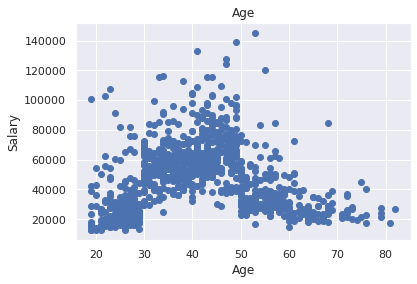

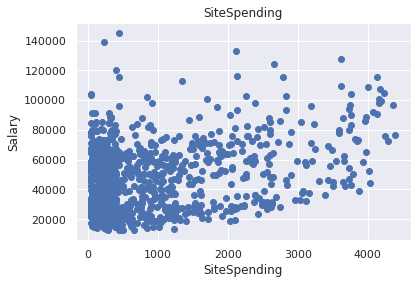

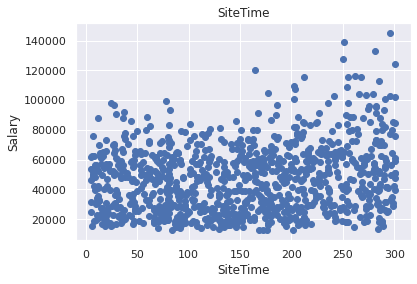

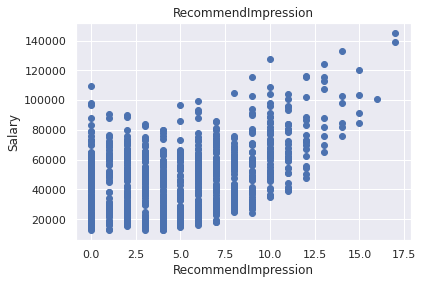

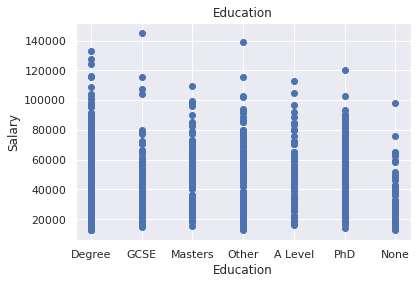

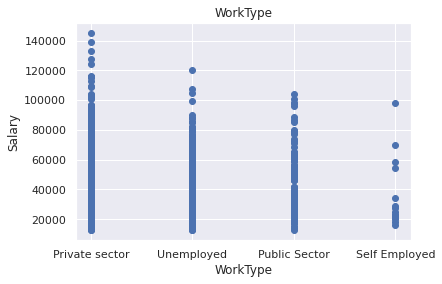

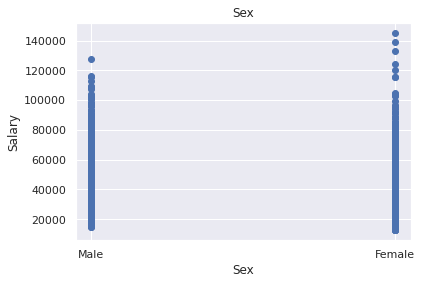

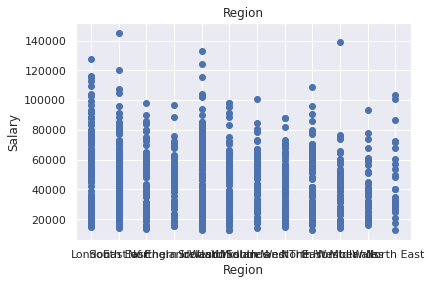

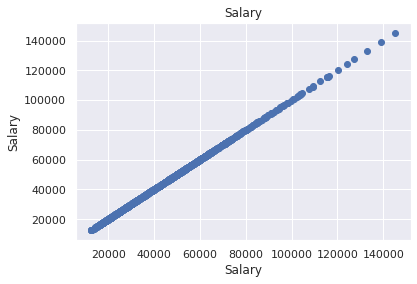

In [271]:
# Plot to the various columns to check for obvious correlelations
for label in df[1:]:
  plt.scatter(df[label], df['Salary'])
  plt.title(label)
  plt.ylabel('Salary')
  plt.xlabel(label)
  plt.show()

In [272]:
#Shuffle the dataset
rng = np.random.default_rng(0) # This sets the random seed, meaning that we will get the SAME random sample if we rerun this cell.
df = df.iloc[rng.permutation(len(df))].reset_index(drop=True) # Shuffle data


In [273]:
# Encoding the categorical Features of our dataset
lblEncoder_X = LabelEncoder()   
df['Education'] = lblEncoder_X.fit_transform(df['Education'])
df['WorkType'] = lblEncoder_X.fit_transform(df['WorkType']) 
df['Sex'] = lblEncoder_X.fit_transform(df['Sex']) 
df['Region'] = lblEncoder_X.fit_transform(df['Region'])

#df = pd.get_dummies(df, drop_first=True)
df.columns

Index(['Age', 'SiteSpending', 'SiteTime', 'RecommendImpression', 'Education',
       'WorkType', 'Sex', 'Region', 'Salary'],
      dtype='object')

In [274]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = df[['Age', 'SiteSpending', 'SiteTime', 'RecommendImpression', 'Education',
       'WorkType', 'Sex', 'Region', 'Salary']] 
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]
vif['Features'] = variables.columns
vif

,VIF,Features
0,6.658374,Age
1,2.113952,SiteSpending
2,7.364734,SiteTime
3,6.055080,RecommendImpression
4,2.540188,Education
5,1.460958,WorkType
6,1.834322,Sex
7,3.426002,Region
8,7.079411,Salary


From the above, we can see there exist no multicolinearity in our data. However, in our scatter plot, site time does not seem to have any obvious correlation with Salary and the VIF is very high. So we can proceed to either drop it or use it and see how much it contributes to our model.

In [275]:
# I assume education is ordinal, so lets order this feature and map it to our dataset:
#enc_dict = {'None': 0, 'Other':1,'GCSE':2, 'A Level':3, 'Degree':4, 'Masters':5,'PhD':6}
#df['Education'] = df['Education'].map(enc_dict):
# This wasn't the case, model performed badly.

# Select Columns
#cols = df[[ 'Age', 'SiteSpending', 'RecommendImpression', 'Education', 'Sex']]
cols = df[['Age', 'SiteSpending', 'RecommendImpression', 'Education',
       'WorkType', 'Sex', 'Region']]

*Declare the dependent and independent Variable*

In [276]:
# Select your features and Target variables
X = np.array(df[cols.columns])
y = np.array(df['Salary'])

# Split Dataset
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split your data on a 80-20 split for training and testing
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.25, random_state=42)

# Poly Transform
degree = 2 # Define the maximum power of polynomial features you want to include
poly = PolynomialFeatures(degree) # Create the polynomial features object
X_train_poly = poly.fit_transform(X_train) # Fit the poly object to the training data to make a new feature matrix
X_test_poly = poly.fit_transform(X_test)
X_val_poly = poly.fit_transform(X_val)

# Standardize your Data
scaler = StandardScaler()
scaler.fit(X_train_poly)
X_train_poly_stded = scaler.transform(X_train_poly)
X_test_poly_stded = scaler.transform(X_test_poly)
X_val_poly_stded = scaler.transform(X_val_poly)



### SKLEARN LINEAR REGRESSION

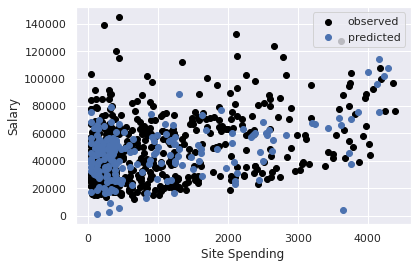

Training Score:  0.732
Validation Score:  0.629
R2 Score:  0.66
MSE:  163153530.831
MAE:  10322.927
Max error:  43033.349


In [277]:
# Create, Train the model and predict on validation and Test Data
obj = sklearn.linear_model.LinearRegression(fit_intercept=True)
obj.fit(X_train_poly_stded, y_train)

y_val_pred = obj.predict(X_val_poly_stded)
y_pred = obj.predict(X_test_poly_stded)

#print(obj.intercept_)
#print(obj.coef_)

plt.scatter(X_train[:,1], y_train, label='observed', color='black')
plt.scatter(X_test[:,1], y_pred, label='predicted')
#plt.plot(np.r_[0:12:0.1], obj.predict(np.r_[0:12:0.1][:, np.newaxis]), color='red', label='hypothesis')
plt.xlabel('Site Spending')
plt.ylabel('Salary')
plt.legend()
plt.show()

print('Training Score: ', round(obj.score(X_train_poly_stded, y_train),3))
print('Validation Score: ', round(sklearn.metrics.r2_score(y_val, y_val_pred),3))

print('R2 Score: ', round(sklearn.metrics.r2_score(y_test, y_pred),3))
print('MSE: ', round(sklearn.metrics.mean_squared_error(y_test, y_pred),3))
print('MAE: ', round(sklearn.metrics.mean_absolute_error(y_test, y_pred),3))
print('Max error: ', round(sklearn.metrics.max_error(y_test, y_pred),3))

# one hot encoding all the categorical features and taking site time out
# we got a training score of 83% and a negative testing score. 
# excluding the region, we get 74% training and 65% testing.

### KERNEL RIDGE LAPLACIAN

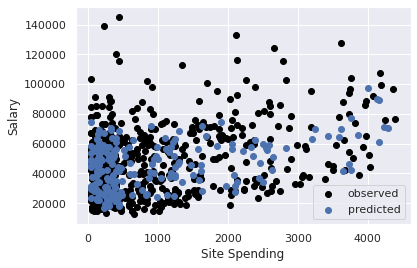

Training Score:  0.854
Validation Score:  0.786
R2 Score:  0.782
MSE:  104653082.3
MAE:  7881.056
Max error:  39440.493


In [278]:
obj = kernel_ridge.KernelRidge(kernel='laplacian')
# 79% with Site time,  83% without site time however it doesnt explain the outliers.
obj.fit(X_train_poly_stded, y_train)
y_val_pred = obj.predict(X_val_poly_stded)
y_pred = obj.predict(X_test_poly_stded)

#print(obj.intercept_)
#print(obj.coef_)

plt.scatter(X_train[:,1], y_train, label='observed', color='black')
plt.scatter(X_test[:,1], y_pred, label='predicted')
plt.xlabel('Site Spending')
plt.ylabel('Salary')
plt.legend()
plt.show()

print('Training Score: ', round(obj.score(X_train_poly_stded, y_train),3))
print('Validation Score: ', round(sklearn.metrics.r2_score(y_val, y_val_pred),3))

print('R2 Score: ', round(sklearn.metrics.r2_score(y_test, y_pred),3))
print('MSE: ', round(sklearn.metrics.mean_squared_error(y_test, y_pred),3))
print('MAE: ', round(sklearn.metrics.mean_absolute_error(y_test, y_pred),3))
print('Max error: ', round(sklearn.metrics.max_error(y_test, y_pred),3))

# one hot encoding score is: 72% on training and 67% on testing.
# 80% training and 74% testing

### KERNEL RIDGE RBF

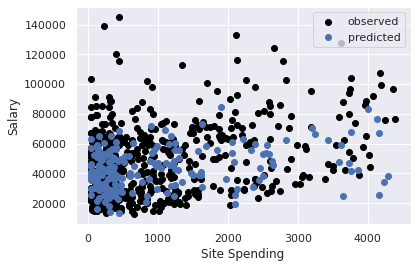

Training Score:  0.698
Validation Score:  0.548
R2 Score:  0.443
MSE:  267184812.192
MAE:  12354.677
Max error:  72572.244


In [279]:
obj = kernel_ridge.KernelRidge(kernel='rbf')
obj.fit(X_train_poly_stded, y_train)

y_val_pred = obj.predict(X_val_poly_stded)
y_pred = obj.predict(X_test_poly_stded)

#print(obj.intercept_)
#print(obj.coef_)

plt.scatter(X_train[:,1], y_train, label='observed', color='black')
plt.scatter(X_test[:,1], y_pred, label='predicted')
#plt.plot(np.r_[0:12:0.1], obj.predict(np.r_[0:12:0.1][:, np.newaxis]), color='red', label='hypothesis')
plt.xlabel('Site Spending')
plt.ylabel('Salary')
plt.legend()
plt.show()

print('Training Score: ', round(obj.score(X_train_poly_stded, y_train),3))
print('Validation Score: ', round(sklearn.metrics.r2_score(y_val, y_val_pred),3))

print('R2 Score: ', round(sklearn.metrics.r2_score(y_test, y_pred),3))
print('MSE: ', round(sklearn.metrics.mean_squared_error(y_test, y_pred),3))
print('MAE: ', round(sklearn.metrics.mean_absolute_error(y_test, y_pred),3))
print('Max error: ', round(sklearn.metrics.max_error(y_test, y_pred),3))

# Obs: 56% with site time, 64% without site time.
# ohe: 54% training and 7% testing.

### POLYNOMIAL

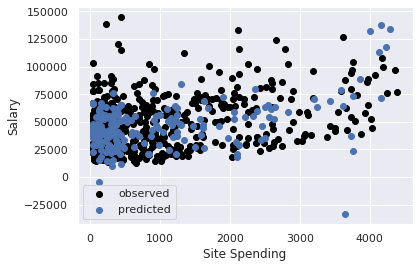

Training Score:  0.817
Validation Score:  0.61
R2 Score:  0.549
MSE:  215988056.506
MAE:  10982.152
Max error:  78791.434
Adjusted R2 on training : 0.8155574828635834
Adjusted R2 on testing : 0.546271542719654


In [280]:
obj = kernel_ridge.KernelRidge(kernel='polynomial')
obj.fit(X_train_poly_stded, y_train)

y_val_pred = obj.predict(X_val_poly_stded)
y_pred = obj.predict(X_test_poly_stded)

#print(obj.intercept_)
#print(obj.coef_)

plt.scatter(X_train[:,1], y_train, label='observed', color='black')
plt.scatter(X_test[:,1], y_pred, label='predicted')
#plt.plot(np.r_[0:12:0.1], obj.predict(np.r_[0:12:0.1][:, np.newaxis]), color='red', label='hypothesis')
plt.xlabel('Site Spending')
plt.ylabel('Salary')
plt.legend()
plt.show()

print('Training Score: ', round(obj.score(X_train_poly_stded, y_train),3))
print('Validation Score: ', round(sklearn.metrics.r2_score(y_val, y_val_pred),3))

print('R2 Score: ', round(sklearn.metrics.r2_score(y_test, y_pred),3))
print('MSE: ', round(sklearn.metrics.mean_squared_error(y_test, y_pred),3))
print('MAE: ', round(sklearn.metrics.mean_absolute_error(y_test, y_pred),3))
print('Max error: ', round(sklearn.metrics.max_error(y_test, y_pred),3))


# obs: 60% with site time,  67% without site time.
r2 = obj.score(X_train_poly_stded, y_train)
n = X.shape[0]
p = X.shape[1]
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
adj_r2
print('Adjusted R2 on training :', adj_r2)

r2 = sklearn.metrics.r2_score(y_test, y_pred)
n = X.shape[0]
p = X.shape[1]
adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
adj_r2
print('Adjusted R2 on testing :', adj_r2)

#ohe: 76% on training and 43% on testing 


### SVM Linear

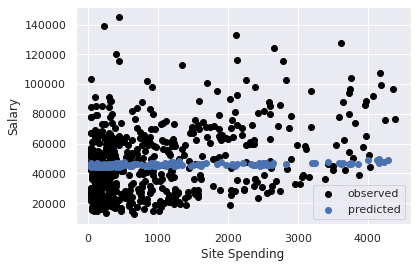

Training Score:  0.045
Validation Score:  0.041
R2 Score:  0.042
MSE:  459262865.68
MAE:  17542.113
Max error:  66744.114


In [281]:
obj = SVR(kernel='linear')
obj.fit(X_train_poly_stded, y_train)

y_val_pred = obj.predict(X_val_poly_stded)
y_pred = obj.predict(X_test_poly_stded)

#print(obj.intercept_)
#print(obj.coef_)

plt.scatter(X_train[:,1], y_train, label='observed', color='black')
plt.scatter(X_test[:,1], y_pred, label='predicted')
#plt.plot(np.r_[0:12:0.1], obj.predict(np.r_[0:12:0.1][:, np.newaxis]), color='red', label='hypothesis')
plt.xlabel('Site Spending')
plt.ylabel('Salary')
plt.legend()
plt.show()

print('Training Score: ', round(obj.score(X_train_poly_stded, y_train),3))
print('Validation Score: ', round(sklearn.metrics.r2_score(y_val, y_val_pred),3))

print('R2 Score: ', round(sklearn.metrics.r2_score(y_test, y_pred),3))
print('MSE: ', round(sklearn.metrics.mean_squared_error(y_test, y_pred),3))
print('MAE: ', round(sklearn.metrics.mean_absolute_error(y_test, y_pred),3))
print('Max error: ', round(sklearn.metrics.max_error(y_test, y_pred),3))

#obs: 6% with site time, 4.8% without site time

**Adjusted R-squared **
\
 $R^2_{adj.} = 1-(1-R^2)*\frac{n-1}{n-p-1}$

### Notes:

1. Just using the numerical features with label encoded sex, and no poly fit, 
    our linear model does 24% and a mean absolute error of 16186 and a max error of 58570

2. Next we assumed eductation is ordinal, encoded it mapped it to our data. This reduced
    our mean absolute error to 15828, max error to 56378 and an R2 score of 27% which is
    much better than 24%.

3. I used label encoding on the education data and this made our model perform badly. 
    with an R2 score of 22.9%, MAE of 16,480 and max error of 58,662.

Based on this observation, I manually map numbers to the education data with PHD=6, and None=0.
4. I label encoded the Worktype feature, but this did not improve the model significantly,
    as we get 27% R2 score and 55638 max error. However, one hot encoding the Worktype
    further reduces the max error to 54611. Less error same R2 is a better model to me.

Since we're begining to one hot encode our data, we'll need to implement the polyfit.
5. Our model does significantly well with an R2 score of 65%, a max error of 49966 and 
    mean absolute error of 9890 which is much better than all the other tests we've run.
    
6. I'm not convinced region contributes to our model, but i'm going to one hot encode it
    and add it to our feature to see how our model performs. Well, as expected, I got a 
    negative R2 score -2.05, a max error of 9.92e+16. However, label encoding the region
    improves the model R2 score to 66.7%, we get a max error of 49851 and an MAE of 9793.

Increased the polynomial degree from 2 to 3 up to 10. The higher we went, the worse our
model performed. 

We've been using SkLearn linear regression to get the tuning right. Let's see if regressions 
will model our data correctly.
 
7. Lastly i'll like to just naively label encode all the categorical features and train the model with this.

Doing this our model is currently doing pretty alright with as high as 83% in laplacian, however, it does not explain the outliers in the age feature for example.
''' 

# **PART 2: BINARY CLASSIFICATION**


In [282]:
# We classify our Target into two categories, those with salary above 35000 or not.

df['target'] = df['Salary'].apply(lambda x: 1 if x > 35000 else 0)

#Shuffle the data again
# Shuffle the dataset again
rng = np.random.default_rng(0)
df = df.iloc[rng.permutation(len(df))].reset_index(drop=True)

#Lets have a look at the numbers
df.target.value_counts() # we see there are more salary above $35000


1    631
0    369
Name: target, dtype: int64

In [283]:
# Even though our model gave usa high accuracy using, i think it's bias towards the 
# salary above 35k cos it's almost 2ce the size of the salary under 35k
# Next lets resample our target and rerun our model.
df_over = df[(df['target']==1)]
df_under = df[(df['target']==0)]

df_undersampled = resample(df_over, replace=True,n_samples= len(df_under),random_state=42)
df_undersampled = pd.concat([df_undersampled, df_under])

df_undersampled['target'].value_counts()

1    369
0    369
Name: target, dtype: int64

In [284]:
df_undersampled.drop(['Salary'], axis=1)
# Declare your target and feature columns
cols = df_undersampled[[ 'Age', 'SiteSpending','RecommendImpression']]

X = np.array(df_undersampled[cols.columns])
y = np.array(df_undersampled['target'])

In [285]:
# Split your data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


In [286]:
#Standardize your dataset
scaler = StandardScaler()
scaler.fit(X_train) # calculate the mean and variance for each feature and store to attributes

X_train = scaler.transform(X_train) # standardize X_train
X_test = scaler.transform(X_test)

### Using Logistic Regression

In [287]:
# Create logistic regression object

obj = sklearn.linear_model.LogisticRegression(penalty='l1', C=10, solver='liblinear',random_state=40)

# Tuning hyperparamters: obj = sklearn.linear_model.LogisticRegression(penalty='l1', C=0.01, solver='liblinear',random_state=40)

# Train the model using the training sets
obj.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = obj.predict(X_test)


The training score: 0.664
Accuracy: 0.6554
Confusion matrix:  [[50 19]
 [32 47]]
              precision    recall  f1-score   support

           0       0.61      0.72      0.66        69
           1       0.71      0.59      0.65        79

    accuracy                           0.66       148
   macro avg       0.66      0.66      0.66       148
weighted avg       0.66      0.66      0.65       148



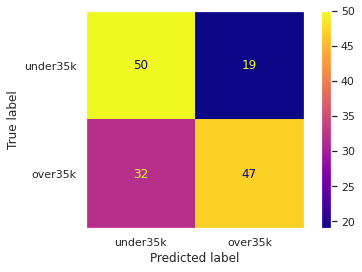

In [288]:
# The accuracy score: 1 for perfect prediction
print("The training score: {:.3f}".format(obj.score(X_train, y_train)))
print('Accuracy: {:.4f}'.format(sklearn.metrics.accuracy_score(y_test, y_pred)))
# Confusion matrix
confusion_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)#, normalize='all')
print('Confusion matrix: ', confusion_mat)
# Visualize the confusion matrix
sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['under35k', 'over35k']).plot(cmap=plt.cm.plasma)
plt.grid(False)
# The classification report, which contains accuracy, precision, recall, F1 score
print(sklearn.metrics.classification_report(y_test, y_pred))

In [289]:
# Checking p-values and removing p-values that are close to 1 as they do not contribute to our model
x1 = sm.add_constant(X_train)
reg_log = sm.Logit(y_train, x1)
results_log = reg_log.fit()
results_log.pred_table()

Optimization terminated successfully.
         Current function value: 0.613605
         Iterations 5


array([[207.,  93.],
       [104., 186.]])

In [290]:
results_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  590
Model:                          Logit   Df Residuals:                      586
Method:                           MLE   Df Model:                            3
Date:                Fri, 16 Dec 2022   Pseudo R-squ.:                  0.1146
Time:                        20:06:59   Log-Likelihood:                -362.03
converged:                       True   LL-Null:                       -408.87
Covariance Type:            nonrobust   LLR p-value:                 3.529e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0220      0.089     -0.246      0.806      -0.197       0.153
x1             0.1537      0.089      1.724      0.085      -0.021       0.328
x2             0.4913      0.096      5.115      0.000       0.303       0.680
x3             0.7497      0.097      7.719      0.000       0.559       0.940
==============================================================================
"""

### using SVM

The training score: 0.953
Accuracy: 0.9459
Confusion matrix:  [[63  6]
 [ 2 77]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        69
           1       0.93      0.97      0.95        79

    accuracy                           0.95       148
   macro avg       0.95      0.94      0.95       148
weighted avg       0.95      0.95      0.95       148



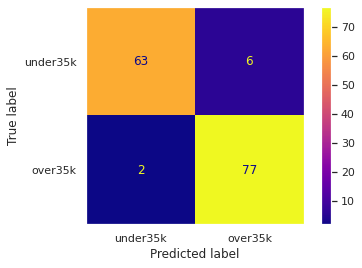

In [291]:
# Tuning hyperparamters: penalty='l1', C=10, solver='liblinear'
import sklearn.svm 

# Create support vector classifier object
obj = sklearn.svm.SVC(C=10,kernel='rbf',random_state=40)

# Train the model using the training sets
obj.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = obj.predict(X_test)

# The higher the better# The accuracy score: 1 for perfect prediction
print("The training score: {:.3f}".format(obj.score(X_train, y_train)))
print('Accuracy: {:.4f}'.format(sklearn.metrics.accuracy_score(y_test, y_pred)))
# Confusion matrix
confusion_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)#, normalize='all')
print('Confusion matrix: ', confusion_mat)
# Visualize the confusion matrix
sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['under35k', 'over35k']).plot(cmap=plt.cm.plasma)
plt.grid(False)
# The classification report, which contains accuracy, precision, recall, F1 score
print(sklearn.metrics.classification_report(y_test, y_pred))

### Using Decision Tree

The training score: 0.964
Accuracy: 0.9459
Confusion matrix:  [[63  6]
 [ 2 77]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        69
           1       0.93      0.97      0.95        79

    accuracy                           0.95       148
   macro avg       0.95      0.94      0.95       148
weighted avg       0.95      0.95      0.95       148



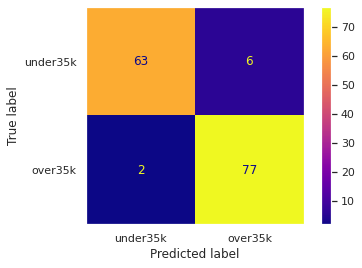

In [292]:
# Create Decison Tree object
from sklearn.tree import DecisionTreeClassifier
obj = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=9,random_state=40)

# Train the model using the training sets
obj.fit(X_train, y_train)

# Make predictions using the testing set
y_new_pred = obj.predict(X_test)

# The higher the better
# The accuracy score: 1 for perfect prediction
print("The training score: {:.3f}".format(obj.score(X_train, y_train)))
print('Accuracy: {:.4f}'.format(sklearn.metrics.accuracy_score(y_test, y_pred)))
# Confusion matrix
confusion_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)#, normalize='all')
print('Confusion matrix: ', confusion_mat)
# Visualize the confusion matrix
sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['under35k', 'over35k']).plot(cmap=plt.cm.plasma)
plt.grid(False)
# The classification report, which contains accuracy, precision, recall, F1 score
print(sklearn.metrics.classification_report(y_test, y_pred))

# **PART 3: NEURAL NETWORK**

In [293]:
df_undersampled.drop(['Salary'], axis=1)
# Declare your target and feature columns
cols = df_undersampled[[ 'Age', 'SiteSpending','RecommendImpression']]

X_nn = np.array(df_undersampled[cols.columns])
y_nn = np.array(df_undersampled['target'])

In [294]:
#Split your data
X_nn_, X_nn_test, y_nn_, y_nn_test = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)
X_nn_train, X_nn_val, y_nn_train, y_nn_val = train_test_split(X_nn_, y_nn_, test_size=0.25, random_state=42)

In [295]:
# Standardize your data
scaler = StandardScaler()
scaler.fit(X_nn_train) # calculate the mean and variance for each feature and store to attributes

X_nn_train = scaler.transform(X_nn_train) # standardize X_train
X_nn_test = scaler.transform(X_nn_test)
X_nn_val = scaler.transform(X_nn_val)

### Random tests

In [296]:
import tensorflow as tf
input_size = 8
output_size = 2
hidden_layer_size = 50

acc = BinaryAccuracy()

model = tf.keras.Sequential([tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                             tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                             tf.keras.layers.Dense(output_size, activation='softmax'),
                             ])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

batch_size = 100
max_epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

model.fit(X_nn_train,y_nn_train,
          batch_size = batch_size, epochs = max_epochs, validation_data= (X_nn_val, y_nn_val),
          callbacks = [early_stopping],
          verbose = 2)

Epoch 1/100
5/5 - 1s - loss: 0.6707 - accuracy: 0.5339 - val_loss: 0.6460 - val_accuracy: 0.5676 - 805ms/epoch - 161ms/step
Epoch 2/100
5/5 - 0s - loss: 0.6405 - accuracy: 0.6109 - val_loss: 0.6148 - val_accuracy: 0.6622 - 49ms/epoch - 10ms/step
Epoch 3/100
5/5 - 0s - loss: 0.6140 - accuracy: 0.6674 - val_loss: 0.5880 - val_accuracy: 0.7027 - 47ms/epoch - 9ms/step
Epoch 4/100
5/5 - 0s - loss: 0.5898 - accuracy: 0.6991 - val_loss: 0.5632 - val_accuracy: 0.7365 - 45ms/epoch - 9ms/step
Epoch 5/100
5/5 - 0s - loss: 0.5703 - accuracy: 0.7353 - val_loss: 0.5408 - val_accuracy: 0.7568 - 49ms/epoch - 10ms/step
Epoch 6/100
5/5 - 0s - loss: 0.5519 - accuracy: 0.7376 - val_loss: 0.5203 - val_accuracy: 0.7635 - 46ms/epoch - 9ms/step
Epoch 7/100
5/5 - 0s - loss: 0.5346 - accuracy: 0.7511 - val_loss: 0.5008 - val_accuracy: 0.7770 - 62ms/epoch - 12ms/step
Epoch 8/100
5/5 - 0s - loss: 0.5188 - accuracy: 0.7534 - val_loss: 0.4817 - val_accuracy: 0.7770 - 43ms/epoch - 9ms/step
Epoch 9/100
5/5 - 0s - los

In [297]:
test_loss, test_accuracy = model.evaluate(X_nn_test, y_nn_test)

5/5 [==============================] - 0s 3ms/step - loss: 0.2323 - accuracy: 0.9122


In [298]:
history = model.fit(X_nn_train,y_nn_train,
          batch_size = batch_size, epochs = max_epochs, validation_data= (X_nn_val, y_nn_val),
          callbacks = [early_stopping],
          verbose = 2)


Epoch 1/100
5/5 - 0s - loss: 0.2455 - accuracy: 0.8982 - val_loss: 0.2330 - val_accuracy: 0.9392 - 110ms/epoch - 22ms/step
Epoch 2/100
5/5 - 0s - loss: 0.2442 - accuracy: 0.9027 - val_loss: 0.2311 - val_accuracy: 0.9257 - 52ms/epoch - 10ms/step
Epoch 3/100
5/5 - 0s - loss: 0.2423 - accuracy: 0.9072 - val_loss: 0.2305 - val_accuracy: 0.9324 - 45ms/epoch - 9ms/step
Epoch 4/100
5/5 - 0s - loss: 0.2397 - accuracy: 0.9005 - val_loss: 0.2309 - val_accuracy: 0.9392 - 65ms/epoch - 13ms/step
Epoch 5/100
5/5 - 0s - loss: 0.2387 - accuracy: 0.8959 - val_loss: 0.2279 - val_accuracy: 0.9392 - 44ms/epoch - 9ms/step
Epoch 6/100
5/5 - 0s - loss: 0.2367 - accuracy: 0.9005 - val_loss: 0.2261 - val_accuracy: 0.9392 - 53ms/epoch - 11ms/step
Epoch 7/100
5/5 - 0s - loss: 0.2357 - accuracy: 0.9027 - val_loss: 0.2293 - val_accuracy: 0.9257 - 51ms/epoch - 10ms/step
Epoch 8/100
5/5 - 0s - loss: 0.2337 - accuracy: 0.9027 - val_loss: 0.2318 - val_accuracy: 0.9324 - 48ms/epoch - 10ms/step


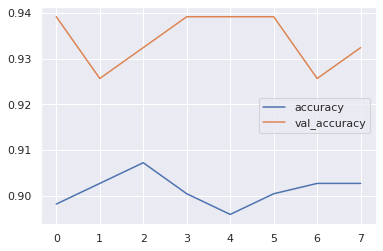

In [299]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

In [300]:
Y_test_logit = model.predict(X_nn_test)


5/5 [==============================] - 0s 3ms/step


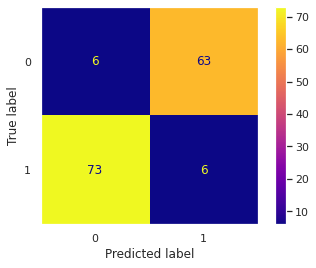

In [301]:
Y_test_pred = (Y_test_logit > 0.5).astype(int) 
# Evaluate the model by plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_nn_test, Y_test_pred[:,0]))
disp.plot(cmap=plt.cm.plasma)
plt.grid(False)

### Main NN Model

In [302]:
# Define the regularizer.
alpha = 0.01
kernel_regularizer = L2(l2=alpha)

# Define the `Dense` layer.
# The output dimension is 1, so we specify `units=1`.
# The as we are performing binary classification, we specify `activation=sigmoid`.
# We apply l2 regularization on the kernel parameters by specifying a `kernel_regularizer` argument.
dense_layer_1 = Dense(units=10, activation=relu, kernel_regularizer=kernel_regularizer)
output_layer = Dense(units=1, activation=sigmoid, kernel_regularizer=kernel_regularizer)

# Define the "virtual" input
input = Input(shape=X_nn_train.shape[1:])

# Define the "virtual" output
output = dense_layer_1(input)
output = output_layer(output)

# Define the neural network model.
model = Model(inputs=[input], outputs=[output])

# Output the summary of the model.
model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_35 (Dense)            (None, 10)                40        
                                                                 
 dense_36 (Dense)            (None, 1)                 11        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [303]:
# Compile the model by specifying the optimization algorithm and the loss function.
# Here, we specify the vanilla stochastic gradient descent 
# (a `tensorflow.keras.optimizers.SGD` instance) as an optimizer,
# and the binary cross entropy function (a `BinaryCrossentropy` instance) 
# as a loss function.

# If we want to observe metrics other than the loss function we specified,
# we can also specify the metrics in the `metrics` parameter 
# in the `compile` method. 

sgd = SGD(learning_rate=0.04)
ce = BinaryCrossentropy()
acc = BinaryAccuracy()
model.compile(optimizer=sgd, loss=ce, metrics=[acc])

Epoch 1/50
5/5 [==============================] - 1s 59ms/step - loss: 0.7524 - binary_accuracy: 0.5430 - val_loss: 0.7295 - val_binary_accuracy: 0.5811
Epoch 2/50
5/5 [==============================] - 0s 12ms/step - loss: 0.7397 - binary_accuracy: 0.5566 - val_loss: 0.7186 - val_binary_accuracy: 0.5946
Epoch 3/50
5/5 [==============================] - 0s 10ms/step - loss: 0.7283 - binary_accuracy: 0.5679 - val_loss: 0.7085 - val_binary_accuracy: 0.5878
Epoch 4/50
5/5 [==============================] - 0s 11ms/step - loss: 0.7181 - binary_accuracy: 0.5882 - val_loss: 0.6991 - val_binary_accuracy: 0.5878
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 0.7089 - binary_accuracy: 0.6086 - val_loss: 0.6906 - val_binary_accuracy: 0.6284
Epoch 6/50
5/5 [==============================] - 0s 10ms/step - loss: 0.7004 - binary_accuracy: 0.6357 - val_loss: 0.6825 - val_binary_accuracy: 0.6554
Epoch 7/50
5/5 [==============================] - 0s 15ms/step - loss: 0.6928 - bi

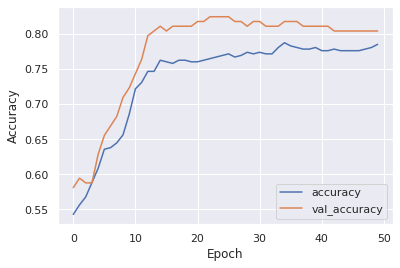

In [304]:
# Train the model.
# `epochs` determines the number of epochs.
# `batch_size` determines the batch_size.

history = model.fit(X_nn_train, y_nn_train, batch_size=90, epochs=50, validation_data=(X_nn_val, y_nn_val))


# Plot validation MSE, alwys nice to have plots to help us visualise things!
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [305]:
ce_test, acc_test = model.evaluate(X_nn_test, y_nn_test)
print('The cross entropy loss on the test data:', ce_test)
print('The accuracy on the test data:', acc_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.5353 - binary_accuracy: 0.7973
The cross entropy loss on the test data: 0.5353154540061951
The accuracy on the test data: 0.7972972989082336


In [306]:
Y_test_logit = model.predict(X_nn_test)
print(Y_test_logit[:10]) # just show you the first 10 to not spam you

5/5 [==============================] - 0s 3ms/step
[[0.91027135]
 [0.5324582 ]
 [0.6529702 ]
 [0.23224595]
 [0.7312142 ]
 [0.6944584 ]
 [0.29540297]
 [0.43163633]
 [0.34733844]
 [0.29564974]]


In [307]:
Y_test_pred = (Y_test_logit > 0.5).astype(int)
print(Y_test_pred[:10])

[[1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]]


The accuracy on the test data with the selected hyperparameter: 0.7972972972972973
The F1 score on the test data with the selected hyperparameter: 0.782608695652174
Precision on validation data: 0.9152542372881356
Recall on validation data: 0.9152542372881356


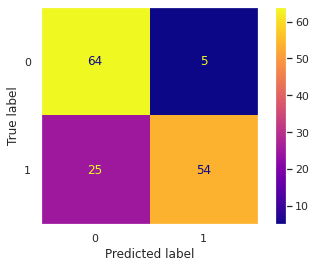

In [316]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_nn_test, Y_test_pred))
disp.plot(cmap=plt.cm.plasma)
plt.grid(False)

acc_test = accuracy_score(y_nn_test, Y_test_pred)
f1_test = f1_score(y_nn_test, Y_test_pred, pos_label=1)
print('The accuracy on the test data with the selected hyperparameter:', acc_test)
print('The F1 score on the test data with the selected hyperparameter:', f1_test)
pre_test = precision_score(y_nn_test, Y_test_pred, pos_label=1)
print('Precision on validation data:', pre_test)
reca_test = precision_score(y_nn_test, Y_test_pred, pos_label=1)
print('Recall on validation data:', reca_test)

# **PART 3: CLUSTERING**

In [309]:
X = df.copy()

## K-Means Clustering

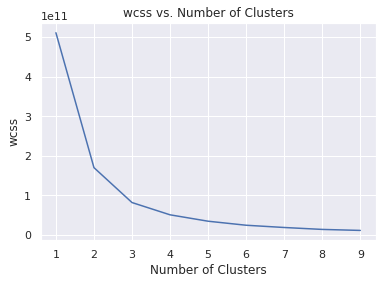

In [310]:
# Trying to find the best number of clusters
# Initialize a list to store the inertia values
wcss = []

# Loop over a range of number of clusters
for i in range(1, 10):
  # Initialize the model with the current number of clusters
  model = KMeans(n_clusters=i, random_state=0)
  
  # Fit the model to the data
  model.fit(X)
  
  # Get the inertia for the model
  inertia = model.inertia_
  
  # Append the inertia to the list
  wcss.append(inertia)

# Plot the inertia values
plt.plot(range(1, 10), wcss)

# Add a title and labels to the plot
plt.title('wcss vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')

# Show the plot
plt.show()

In [311]:
# Initialize the model with gotten k
model = KMeans(n_clusters=4, random_state=0)

# Fit the model to the data
model.fit(X)

# Predict the clusters for each data point
predictions = model.predict(X)


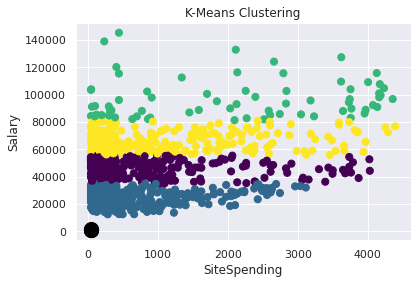

In [312]:
# Select the columns to use for the x and y axes
x_column = 'SiteSpending'
y_column = 'Salary'

# Extract the values for the x and y axes
x = df[x_column]
y = df[y_column]

# Get the cluster labels for each data point
labels = model.predict(X)

# Create a scatter plot of the data
plt.scatter(x, y, c=labels, cmap='viridis', s=50)

# Add the cluster centers to the plot
centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200);

# Add the x and y labels and a title
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title('K-Means Clustering')
plt.show()

In [313]:
x_scaled = preprocessing.scale(X)
model = KMeans(n_clusters=4, random_state=0)

# Fit the model to the data
model.fit(x_scaled)

# Predict the clusters for each data point
predictions = model.predict(x_scaled)

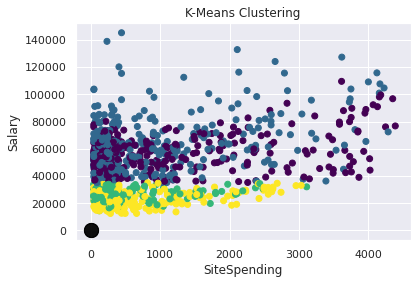

In [314]:
# Select the columns to use for the x and y axes
x_column = 'SiteSpending'
y_column = 'Salary'

# Extract the values for the x and y axes
x = df[x_column]
y = df[y_column]

# Get the cluster labels for each data point
labels = model.predict(x_scaled)

# Create a scatter plot of the data
plt.scatter(x, y, c=labels, cmap='viridis')

# Add the cluster centers to the plot
centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# Add the x and y labels and a title
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title('K-Means Clustering')

# Show the plot
plt.show()

In [315]:
from sklearn.metrics import silhouette_score
print(silhouette_score(x_scaled, labels))

0.17117942704579303
